In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score

# Electric Vehicle Purchase Prediction Project Report

# Step 1: Load Dataset

In [2]:
# Loading the data
df_train = pd.read_csv('EV_train.csv')
X_test = pd.read_csv('EV_X_test.csv')

# Separating target variable and features
y = df_train['BuyEV']
X = df_train.drop(['BuyEV'], axis=1)

# Inspect the first few rows
print(X.head())

   PriceBudgetRatio  range  HomeSlowChgWalkTime  WorkSlowChgWalkTime  \
0              0.70    400                   10                    2   
1              0.70    400                   20                    1   
2              0.70    100                    5                    5   
3              0.85    100                    0                    5   
4              1.00    300                    3                    5   

   FastChgTime TownToFastChgDriveTime HwyFastChgDistance  gender   race  \
0           60                      5                 50       1  White   
1           15                     10                 50       1  White   
2            5                      5                 70       0  White   
3           60                      5                 70       0  White   
4           15                     no                 30       1  White   

          state  ... used  NextCarBudget  PopDensity  orphan  ev_owner  \
0      Virginia  ...    0          50000  

# Step 2: Preprocessing

In [3]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Step 3: Model Development

# Trial #1 with RandomForestClassifier
Selection Rationale: Chosen for its robustness in handling mixed data types and its capacity for capturing complex interactions between features.
Initial Model: A pipeline comprising the preprocessing steps and a RandomForestClassifier is established.

In [4]:
# Define the model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state=42))])


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Hyperparameter Tuning
Method: Employed RandomizedSearchCV to explore a wide range of hyperparameter combinations efficiently.
Results: The optimal configuration achieved a cross-validation score of 75.3%, with parameters set to n_estimators=300, max_depth=30, min_samples_split=2, and min_samples_leaf=1

In [6]:
# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]}

# Execute search
search = RandomizedSearchCV(clf, param_grid, n_jobs=-1, n_iter=10, cv=5, scoring='accuracy', random_state=42)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.753):
{'classifier__n_estimators': 300, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 30}


# Step 4: Model Evaluation

# Validation Set Performance (Accuracy of 78.81% on the validation set)
Accuracy: The model demonstrated an accuracy of 78.81% on the validation set, indicating a strong predictive capability.
Precision and Recall: Achieved balanced precision and recall across both classes, with slightly higher performance in predicting positive cases (EV purchases).

In [7]:
# Predicting on validation set
pred_val = search.predict(X_val)

# Evaluating the model
print("Validation Set Accuracy: ", accuracy_score(y_val, pred_val))
print(classification_report(y_val, pred_val))
print("Confusion Matrix:\n", confusion_matrix(y_val, pred_val))


Validation Set Accuracy:  0.788135593220339
              precision    recall  f1-score   support

           0       0.78      0.69      0.74       402
           1       0.79      0.86      0.82       542

    accuracy                           0.79       944
   macro avg       0.79      0.78      0.78       944
weighted avg       0.79      0.79      0.79       944

Confusion Matrix:
 [[279 123]
 [ 77 465]]


# Trial#2 with Random Forest Classifier


A RandomForestClassifier was again applied with different parameters.

Hyperparameter Tuning: Utilizing RandomizedSearchCV and GridSearchCV, we identified optimal hyperparameters for the model. The best parameters included using 200 trees, a maximum depth of 50, and the sqrt option for maximum features, among others.
Model Accuracy: The model achieved an accuracy of approximately 78.28% on the validation set, indicating a strong predictive capability.

In [9]:
# Assuming `X` is your features DataFrame and you've already done the train-test split

# Define categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# If 'zipcode' is a feature to be removed or handled differently, ensure it's excluded
# This line assumes 'zipcode' is in your list; adjust as necessary
if 'zipcode' in numerical_cols:
    numerical_cols.remove('zipcode')

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the complete pipeline
my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Now, set up your GridSearchCV with the extended parameter grid
extended_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 30, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 0.5],
    'classifier__bootstrap': [True, False]
}

# Set up the GridSearchCV
extended_grid_search = GridSearchCV(my_pipeline, extended_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model with the extended grid
extended_grid_search.fit(X_train, y_train)

# Output the best parameters and accuracy
print("Best parameters with extended grid:", extended_grid_search.best_params_)
best_model_extended = extended_grid_search.best_estimator_
best_preds_extended = best_model_extended.predict(X_val)
best_score_extended = accuracy_score(y_val, best_preds_extended)
print('Best Accuracy with extended grid:', best_score_extended)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, 

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=1

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=1

[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifi

[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifi

[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifi

[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classif

[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifi

[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifi

[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifi

[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   3.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   7.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier

Best parameters with extended grid: {'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best Accuracy with extended grid: 0.7828389830508474


# Step 5: Final Model Selection

# Extended Hyperparameter Grid (Highest Accuracy of 79.66%)
A subsequent GridSearchCV with an expanded parameter grid further refined the model, achieving a best accuracy of 79.66%.
Best Parameters: Included n_estimators=400, max_depth=30, and bootstrap=True, among others.

In [10]:

# Extended Hyperparameter Grid
param_grid = {
    'classifier__n_estimators': [200, 300, 400],
    'classifier__max_depth': [None, 30, 50, 70],
    'classifier__min_samples_split': [2, 5, 10, 15],
    'classifier__min_samples_leaf': [1, 2, 4, 6],
    'classifier__max_features': ['sqrt'],  # Using 'sqrt' as the option for max features
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(my_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Output the best parameters and model evaluation
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
preds = best_model.predict(X_val)
print('Best Accuracy:', accuracy_score(y_val, preds))

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=  10.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   7.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   9.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   9.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifie

[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   9.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   7.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   9.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   9.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classif

[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   9.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   7.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   9.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   9.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classif

[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   4.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   4.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   9.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   7.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classi

[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   9.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   6.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   4.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   7.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifi

[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   6.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   9.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   8.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   4.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classif

[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   4.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   7.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   4.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   4.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifie

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=15, classifier__n_estimators=300; total time=   3.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classi

[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classif

[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=15, classi

[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=400; total time=   4.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=400; total time=   4.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=15, classi

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=15, classifier__n_estimators=400; total time=   3.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=400; total time=   4.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classi

[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=400; total time=   4.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=400; total time=   4.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classif

[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=400; total time=   4.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=15, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=15, classifier__n_estimators=400; total time=   4.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classi

[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=400; total time=   4.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=15, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=15, classifier__n_estimators=400; total time=   4.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, class

[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifi

[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=15, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=15, class

[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   4.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=15, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=15, class

[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=400; total time=   4.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=15, classifier__n_estimators=300; total time=   3.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=15, classifier__n_estimators=400; total time=   3.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=2, class

[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=400; total time=   4.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=400; total time=   4.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=15, classifier__n_estimators=300; total time=   3.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=15, class

[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=2, classifier__n_estimators=400; total time=   3.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=5, classifier__n_estimators=400; total time=   4.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=10, classifi

[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=2, classifier__n_estimators=400; total time=   3.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=5, classifier__n_estimators=400; total time=   4.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=10, classifi

[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   3.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=5, classifier__n_estimators=400; total time=   4.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=10, classifier__n_estimators=400; total time=   4.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=15, classifier__n_estimators=200; total time=   3.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=70, classifier__max_features=sqrt, classifier__min_samples_leaf=6, classifier__min_samples_split=15, classi

Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 30, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 400}
Best Accuracy: 0.7966101694915254
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=400; total time=   4.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=15, classifier__n_estimators=300; total time=   4.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=15, classifier__n_estimators=400; total time=   4.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples

[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=400; total time=   5.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=15, classifier__n_estimators=300; total time=   4.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=15, classifier__n_estimators=400; total time=   4.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   4.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, c

[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   4.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   4.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=15, classifier__n_estimators=200; total time=   3.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=15, 

[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   4.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   4.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=400; total time=   5.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, cla

[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=15, classifier__n_estimators=300; total time=   4.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   4.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, cla

[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   3.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   4.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   4.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=10, c

[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   4.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   4.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=400; total time=   4.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=15, 

In [12]:
# Please strictly follow the naming requirements

# Making predictions with the best model

pred_test = best_model.predict(X_test)
# Convert predictions array to pandas DataFrame
predictions_test_df = pd.DataFrame(pred_test)

# 'EV_test_pred_NetID.csv'. Make sure you use your lower-case netID.
predictions_test_df.to_csv('EV_test_pred_fb4097.csv', index=False, header=False)

# Cross-Validation and Extended Hyperparameter Grid (Accuracy of 78.5%)
To further validate our model's performance and explore the parameter space:

Stratified K-Fold Cross-Validation: This technique ensured that each fold of our dataset had the same proportion of target variable classes, providing a more reliable assessment of model performance.
Extended Hyperparameter Search: An extended search grid included more options for n_estimators, max_depth, min_samples_split, and other parameters. This approach led to identifying a configuration that achieved a cross-validated accuracy of 78.5%.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Ensure numerical_cols and categorical_cols are correctly defined
# numerical_cols = ['num_feature1', 'num_feature2']  # Example, replace with actual numerical column names
# categorical_cols = ['cat_feature1', 'cat_feature2']  # Example, replace with actual categorical column names

# Define the preprocessor as before
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', StandardScaler())]), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the complete pipeline with the RandomForestClassifier
my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid correctly with the 'classifier' prefix
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt'],
    'classifier__bootstrap': [True, False]
}

# GridSearchCV with the corrected parameter grid and cross-validation strategy
grid_search = GridSearchCV(my_pipeline, param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X, y)  # Assuming X and y are correctly defined

# Best parameters and model evaluation
print("Best parameters:", grid_search.best_params_)
print('Best Cross-Validated Accuracy:', grid_search.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 30, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Best Cross-Validated Accuracy: 0.7844426820281467


# Comparison with XGBoost (Lowest Accuracy of 77.66%)

Model Exploration
An XGBoost model was also evaluated using a separate hyperparameter grid to compare performance.
Best XGBoost Performance: Achieved a slightly lower accuracy of 77.66%, indicating that the RandomForestClassifier was more suited to this dataset.

In [26]:
from xgboost import XGBClassifier

# Extended hyperparameter grid for XGBoost
xgb_extended_param_grid = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [6, 10, 15, 20],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
}

# Define the XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# GridSearchCV for XGBoost with extended hyperparameters
xgb_extended_grid_search = GridSearchCV(xgb_pipeline, xgb_extended_param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=2)
xgb_extended_grid_search.fit(X, y)

# Best parameters and accuracy for XGBoost
print("XGBoost - Best parameters:", xgb_extended_grid_search.best_params_)
print("XGBoost - Best accuracy:", xgb_extended_grid_search.best_score_)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   4.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   5.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   4.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   5.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, 

[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=300, model__subsample=0.8; total time=   6.2s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=400, model__subsample=0.6; total time=   6.4s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=400, model__subsample=1.0; total time=   7.1s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=20, model__n_estimators=100, model__subsample=0.6; total time=   4.6s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=20, model__n_estimators=100, model__subsample=1.0; total time=   4.9s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=20, model__n_estimators=200, model__subsample=0.6; total time=   5.1s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=20, mo

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   5.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   5.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   4.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   4.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=1

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   5.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   4.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   4.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   5.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   5.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   5.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   5.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   4.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=1

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   4.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   5.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   4.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   5.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   4.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   5.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   4.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   5.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10

[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=400, model__subsample=0.6; total time=   4.8s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=400, model__subsample=1.0; total time=   4.6s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=10, model__n_estimators=100, model__subsample=0.6; total time=   4.3s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=10, model__n_estimators=100, model__subsample=1.0; total time=   4.4s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=10, model__n_estimators=200, model__subsample=0.6; total time=   4.8s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=10, model__n_estimators=200, model__subsample=1.0; total time=   4.7s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.1, model__max_depth=10, model__n_es

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   4.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   5.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   5.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   5.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   4.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   6.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   5.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   5.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10

XGBoost - Best parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 200, 'model__subsample': 0.6}
XGBoost - Best accuracy: 0.7765967341876808


# XGBoost Classifier
Exploring advanced modeling techniques, we integrated an XGBoostClassifier into our pipeline:

Extended Hyperparameter Tuning for XGBoost: The tuning process considered a wide range of parameters, including learning_rate, max_depth, subsample, and colsample_bytree.
Performance: The XGBoost model demonstrated excellent performance, achieving a cross-validated accuracy of approximately 78% and a ROC AUC score of 0.848, highlighting its strong discriminative power between the classes.
Final Model Insights

Cross-Validated Predictions
The best RandomForest model was assessed across the full dataset using cross-validation, emphasizing its generalization capability.
ROC AUC Score: Achieved a robust score of 0.8478, underscoring the model's excellent class discrimination ability.

In [27]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_predict

# Re-train the model with the best parameters on the full dataset
best_params = {
    'bootstrap': True,
    'max_depth': 70,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 300
}

# Initialize the model with the best parameters
best_model = RandomForestClassifier(**best_params, random_state=42)

# Integrate the best model into a new pipeline (assuming preprocessor is defined as before)
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])

# Use cross_val_predict to generate predictions for calculating additional metrics
y_pred = cross_val_predict(final_pipeline, X, y, cv=cv_strategy, method='predict')
y_scores = cross_val_predict(final_pipeline, X, y, cv=cv_strategy, method='predict_proba')[:, 1]  # Scores for ROC AUC

# Classification report (precision, recall, F1-score)
print("Classification Report:\n", classification_report(y, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y, y_scores)
print("ROC AUC Score:", roc_auc)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.70      0.74      2107
           1       0.77      0.84      0.81      2611

    accuracy                           0.78      4718
   macro avg       0.78      0.77      0.77      4718
weighted avg       0.78      0.78      0.78      4718

ROC AUC Score: 0.8478371869442869
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=10, model__n_estimators=200, model__subsample=0.6; total time=   5.2s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=10, model__n_estimators=200, model__subsample=0.8; total time=   5.5s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=10, model__n_estimators=300, model__subsample=0.6; total time=   5.7s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=10, model__n_estimators=300, model__subsample=0.8; total time=   5.9s
[CV] EN

[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=100, model__subsample=0.6; total time=   4.2s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=100, model__subsample=1.0; total time=   4.0s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=200, model__subsample=0.6; total time=   4.2s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=200, model__subsample=1.0; total time=   4.3s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=300, model__subsample=0.6; total time=   4.6s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=300, model__subsample=1.0; total time=   4.5s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_

[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=100, model__subsample=0.6; total time=   4.2s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=100, model__subsample=0.8; total time=   4.0s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=200, model__subsample=0.6; total time=   4.3s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=200, model__subsample=1.0; total time=   4.3s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=300, model__subsample=0.6; total time=   4.6s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=300, model__subsample=1.0; total time=   4.5s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_

[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=100, model__subsample=0.8; total time=   4.0s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=200, model__subsample=0.6; total time=   4.3s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=200, model__subsample=0.8; total time=   4.3s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=300, model__subsample=0.6; total time=   4.6s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=300, model__subsample=1.0; total time=   4.4s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=400, model__subsample=0.6; total time=   4.7s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_

[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=100, model__subsample=0.8; total time=   5.0s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=100, model__subsample=1.0; total time=   5.2s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=200, model__subsample=0.8; total time=   6.1s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=200, model__subsample=1.0; total time=   6.5s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=300, model__subsample=0.8; total time=   6.9s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=400, model__subsample=0.6; total time=   7.3s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=15, mo

[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=10, model__n_estimators=200, model__subsample=1.0; total time=   5.5s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=10, model__n_estimators=300, model__subsample=0.8; total time=   5.9s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=10, model__n_estimators=300, model__subsample=1.0; total time=   6.2s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=10, model__n_estimators=400, model__subsample=0.8; total time=   6.4s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=100, model__subsample=0.6; total time=   4.8s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=100, model__subsample=0.8; total time=   5.3s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=15, mo

[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=300, model__subsample=0.8; total time=   4.5s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=400, model__subsample=0.6; total time=   4.7s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=400, model__subsample=0.8; total time=   4.8s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=10, model__n_estimators=100, model__subsample=0.6; total time=   4.5s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=10, model__n_estimators=100, model__subsample=0.8; total time=   4.6s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=10, model__n_estimators=200, model__subsample=0.6; total time=   5.1s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=10, model

# EDA & Visualizations:

# Target Variable Analysis

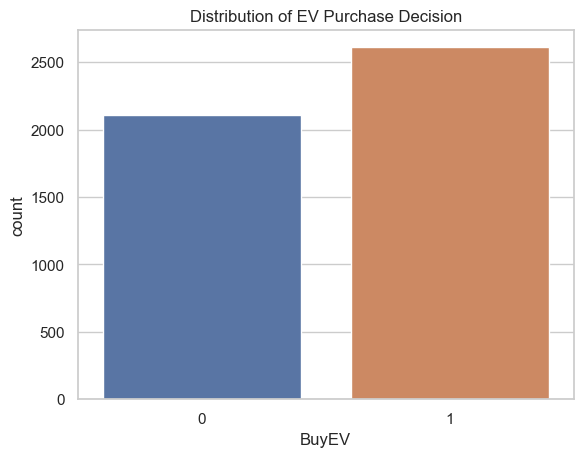

1    55.341246
0    44.658754
Name: BuyEV, dtype: float64


In [3]:
# Distribution of target variable
sns.countplot(x='BuyEV', data=df_train)
plt.title('Distribution of EV Purchase Decision')
plt.show()

# Percentage of each class
print(df_train['BuyEV'].value_counts(normalize=True) * 100)


# Numerical Data Analysis

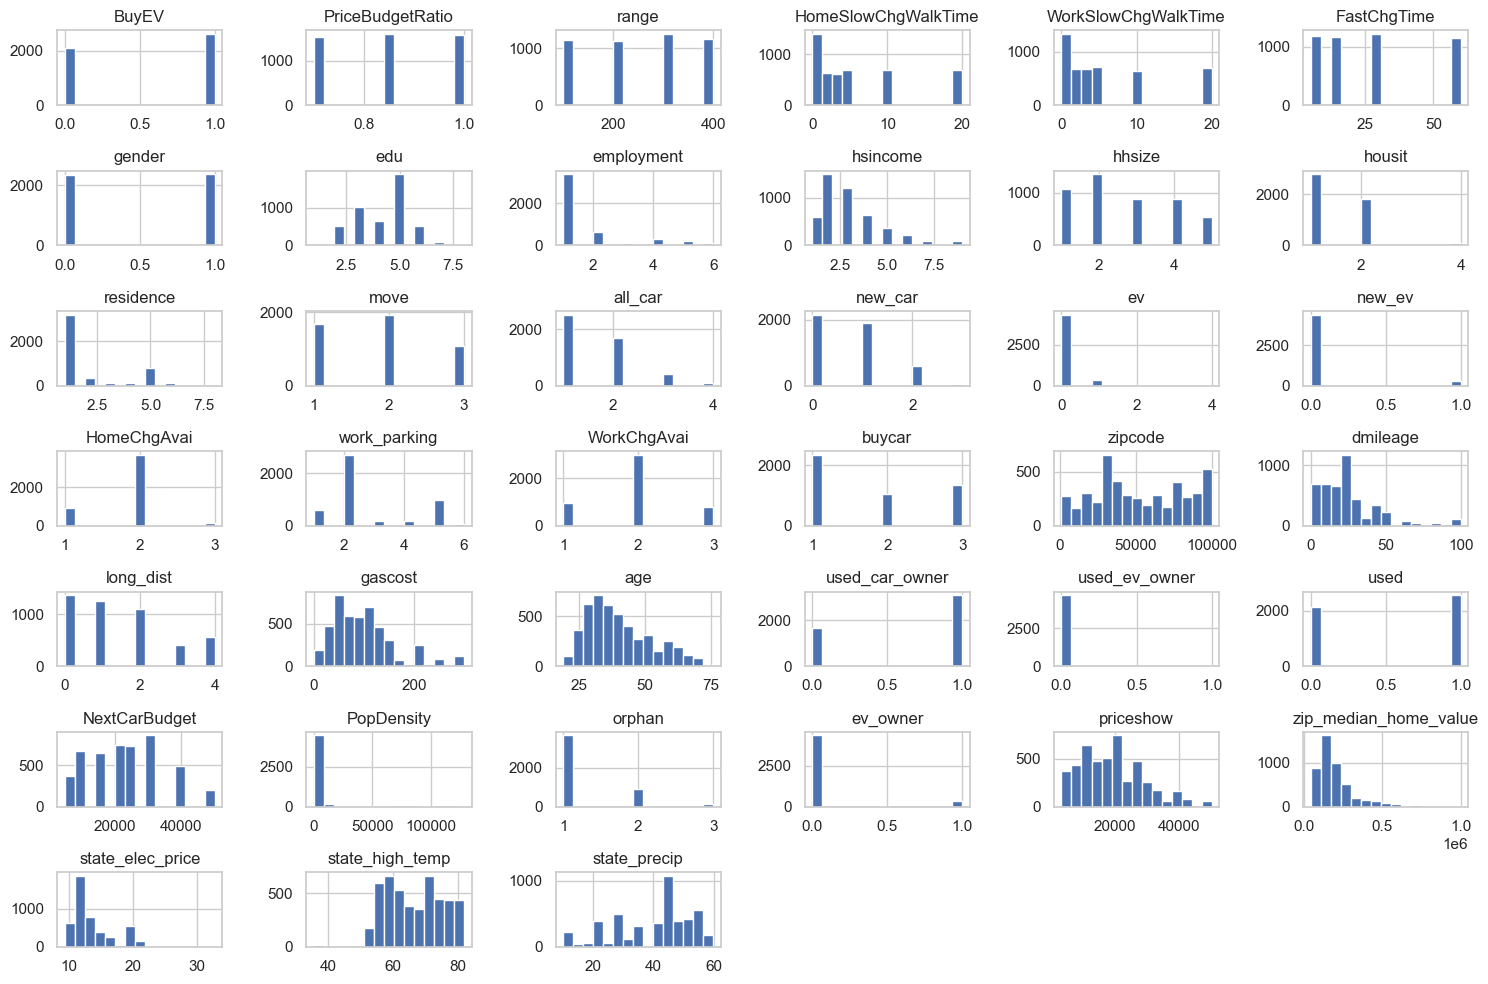

In [5]:
import math

# Number of numerical columns
num_numerical_cols = len(df_train.select_dtypes(include=['int64', 'float64']).columns)

# Calculate the required number of rows/columns
# Here, we aim for a roughly square layout that fits all columns
num_rows = math.ceil(math.sqrt(num_numerical_cols))
num_cols = math.ceil(num_numerical_cols / num_rows)

# Plot with an adjusted layout
df_train.hist(bins=15, figsize=(15, 10), layout=(num_rows, num_cols))
plt.tight_layout()  # Adjust layout to minimize overlapping
plt.show()


# Categorical Data Analysis

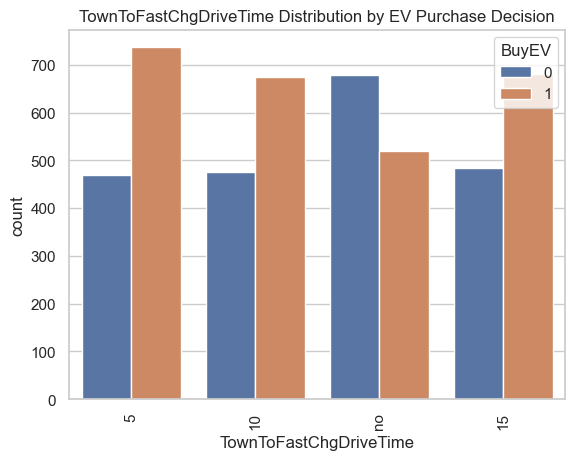

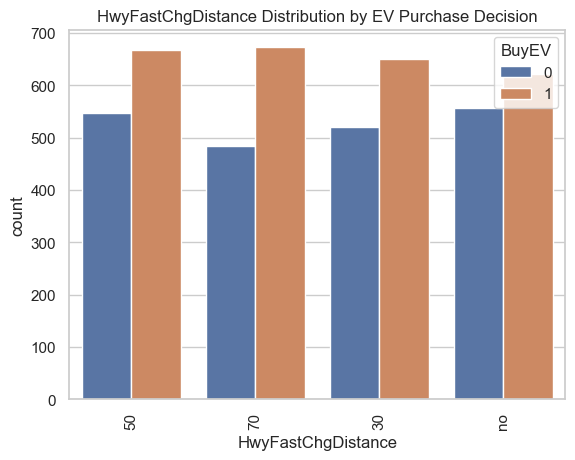

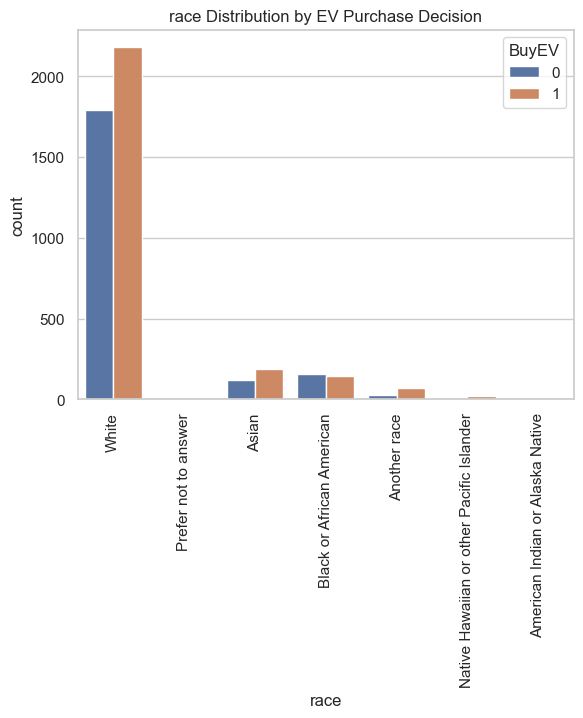

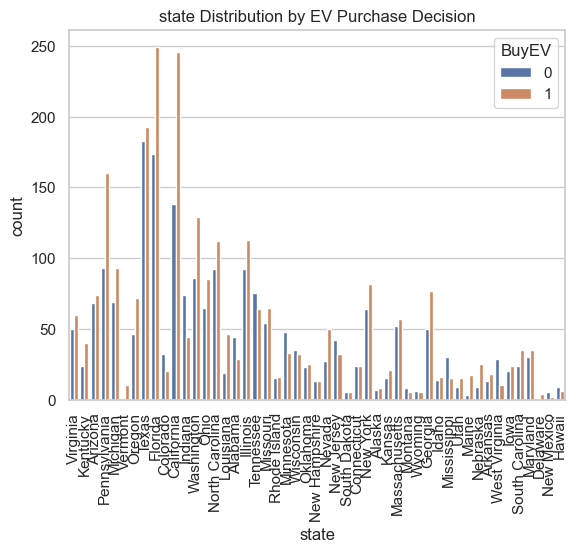

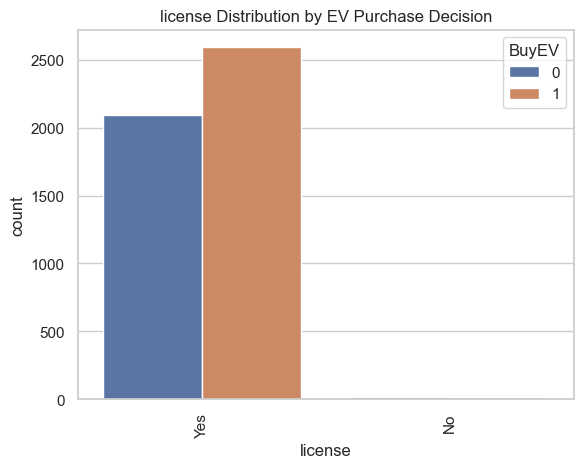

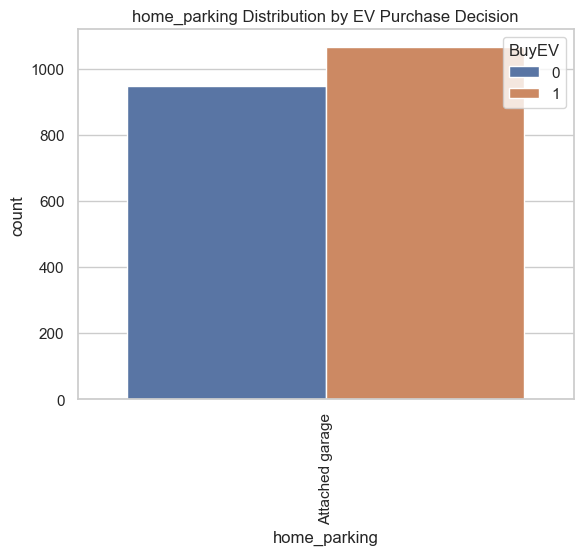

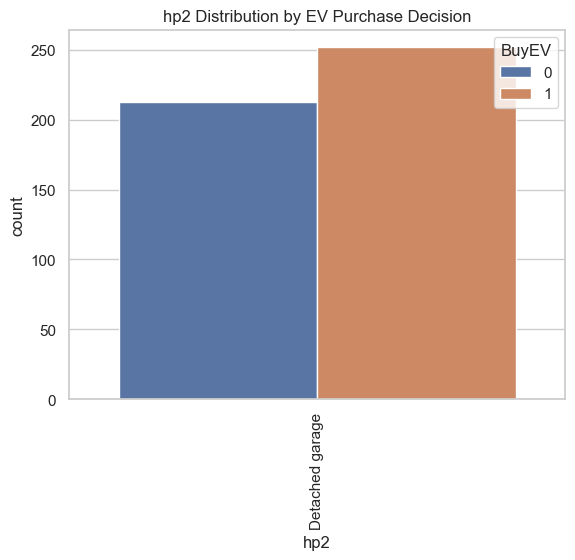

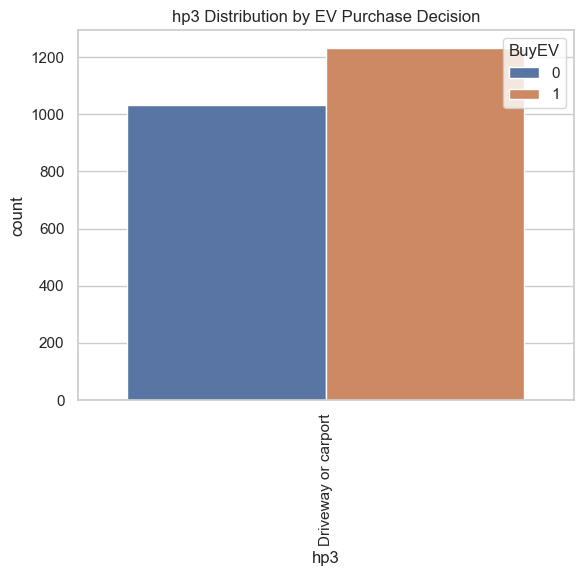

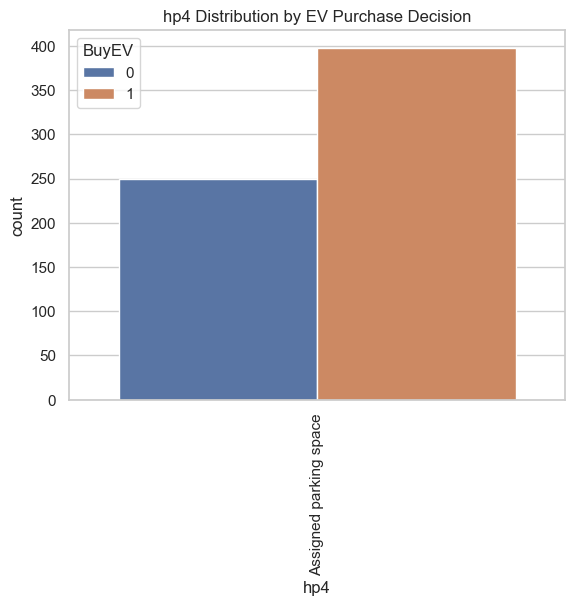

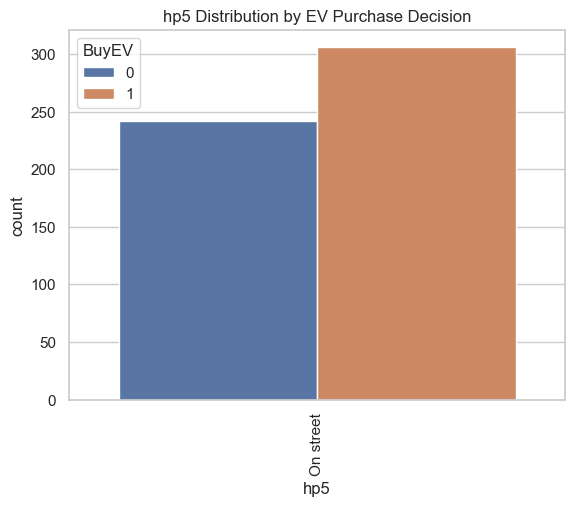

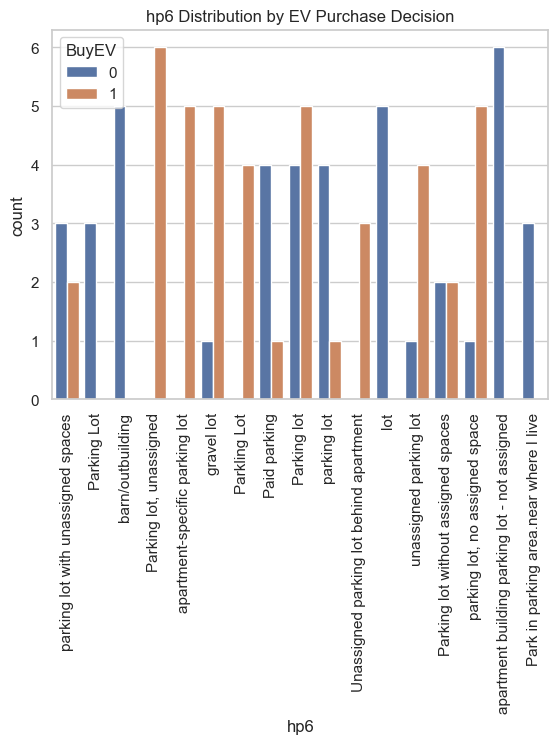

In [20]:
# Countplots for categorical features
categorical_cols = df_train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    sns.countplot(x=col, hue='BuyEV', data=df_train)
    plt.title(f'{col} Distribution by EV Purchase Decision')
    plt.xticks(rotation=90)
    plt.show()

# Count Plots for Categorical Features with Many Levels

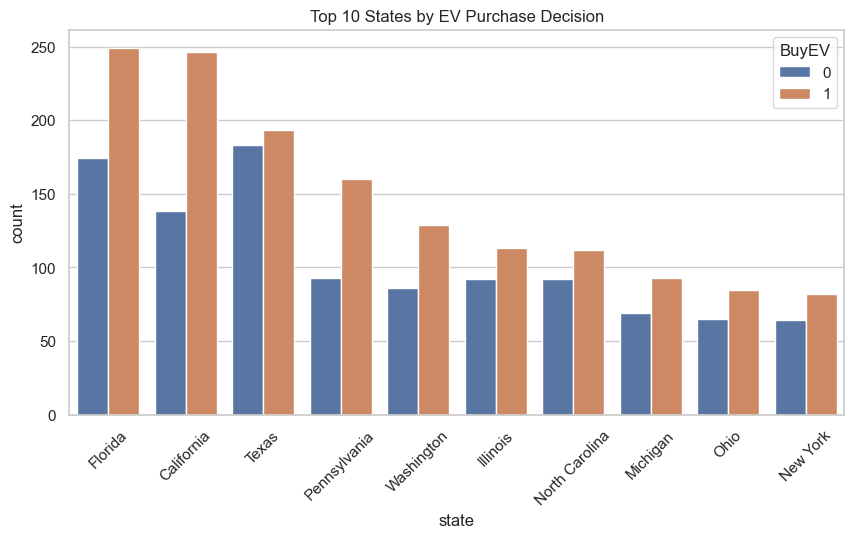

In [28]:
# Count plot for a categorical feature with many levels
top_n = df_train['state'].value_counts().index[:10]  # Top 10 states
plt.figure(figsize=(10, 5))
sns.countplot(data=df_train[df_train['state'].isin(top_n)], x='state', order=top_n, hue='BuyEV')
plt.title('Top 10 States by EV Purchase Decision')
plt.xticks(rotation=45)
plt.show()

# Heatmap of Count/Frequency Cross Tabulation

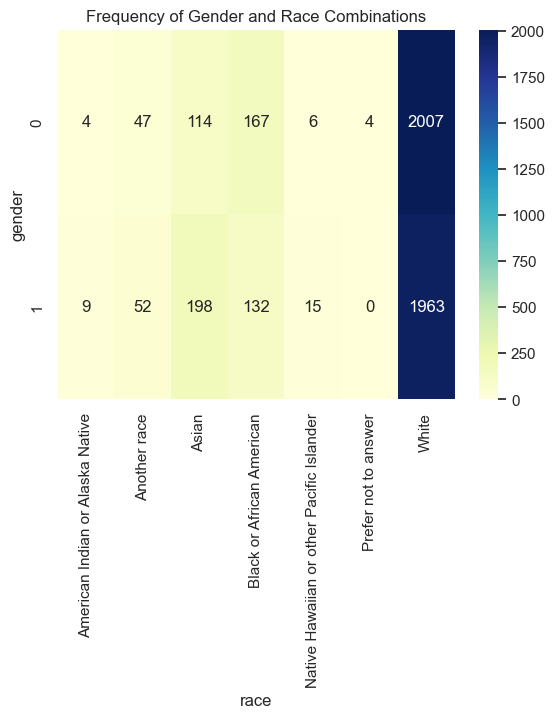

In [30]:
# Heatmap of frequency cross tabulation for two categorical features
crosstab = pd.crosstab(index=df_train['gender'], columns=df_train['race'])
sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Frequency of Gender and Race Combinations')
plt.show()

# Stacked Bar Chart for Categorical Comparison

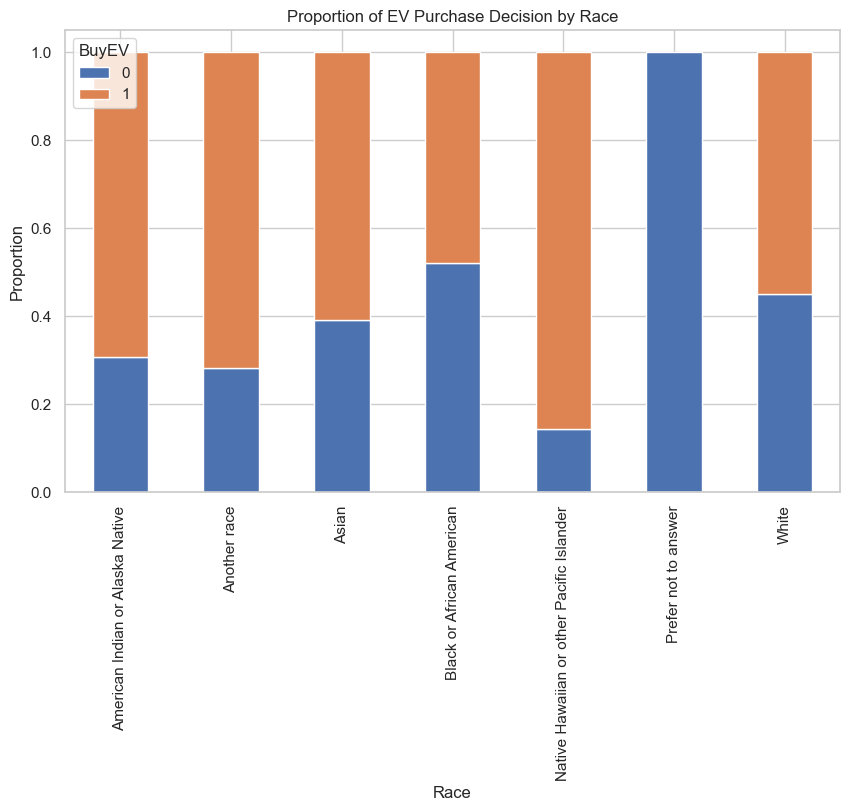

In [38]:
# Creating a stacked bar chart
cross_tab = pd.crosstab(df_train['race'], df_train['BuyEV'], normalize='index')
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proportion of EV Purchase Decision by Race')
plt.xlabel('Race')
plt.ylabel('Proportion')
plt.legend(title='BuyEV', loc='upper left')
plt.show()

# Correlation Heatmap

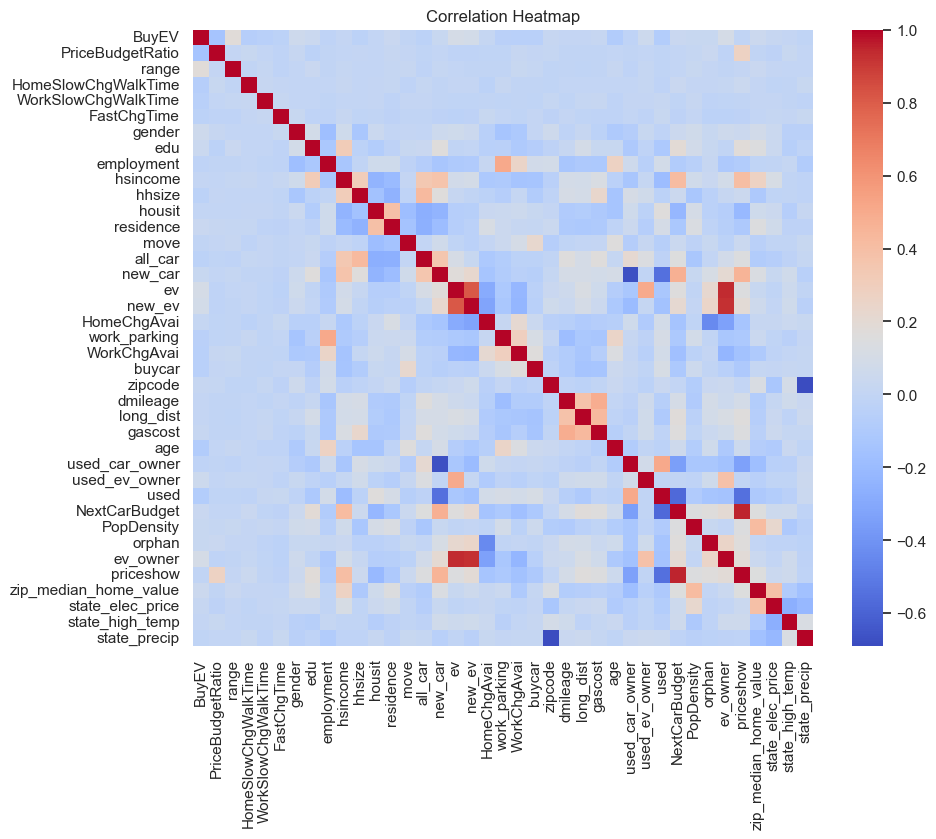

In [13]:
# Correlation matrix focusing on the target variable
correlation_matrix = df_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# Boxplot for Numerical Features by Target

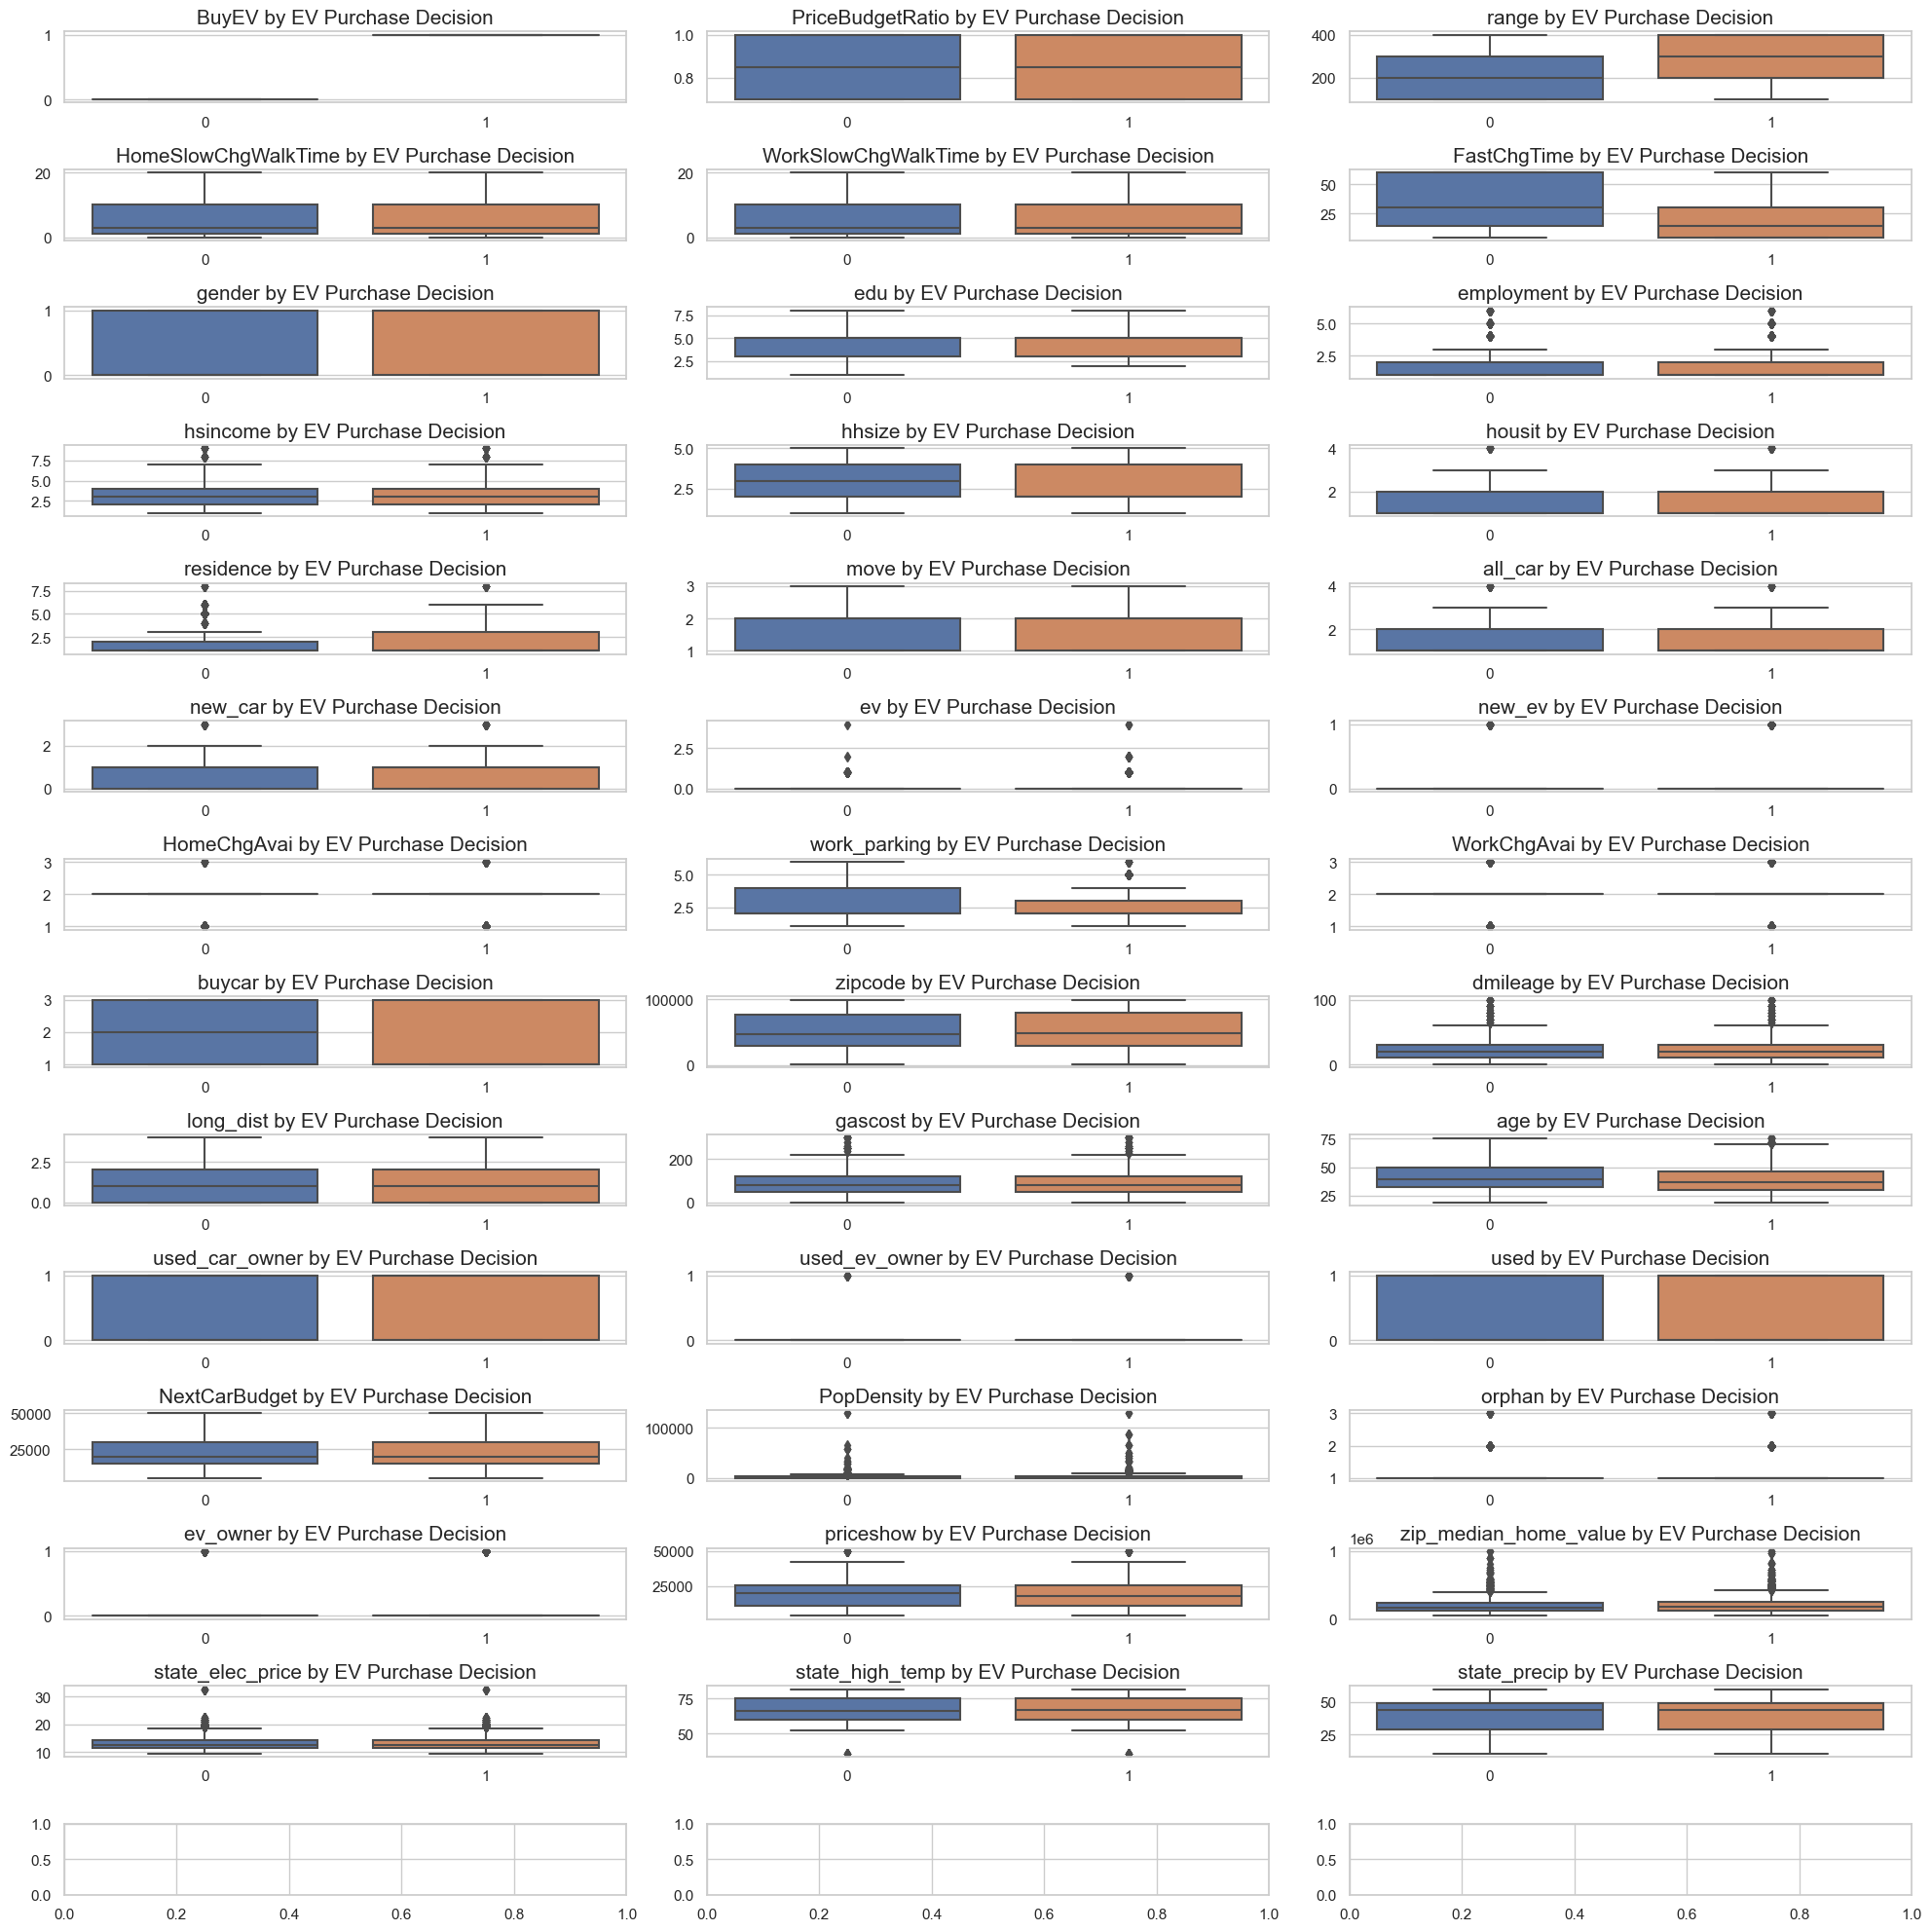

In [14]:
# Creating boxplots of numerical features against the target variable
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
fig, ax = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(20, 20))
ax = ax.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x='BuyEV', y=col, data=df_train, ax=ax[i])
    ax[i].set_title(f'{col} by EV Purchase Decision', fontsize=15)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
plt.tight_layout()
plt.show()


# Pairwise Relationships with Scatter Plots

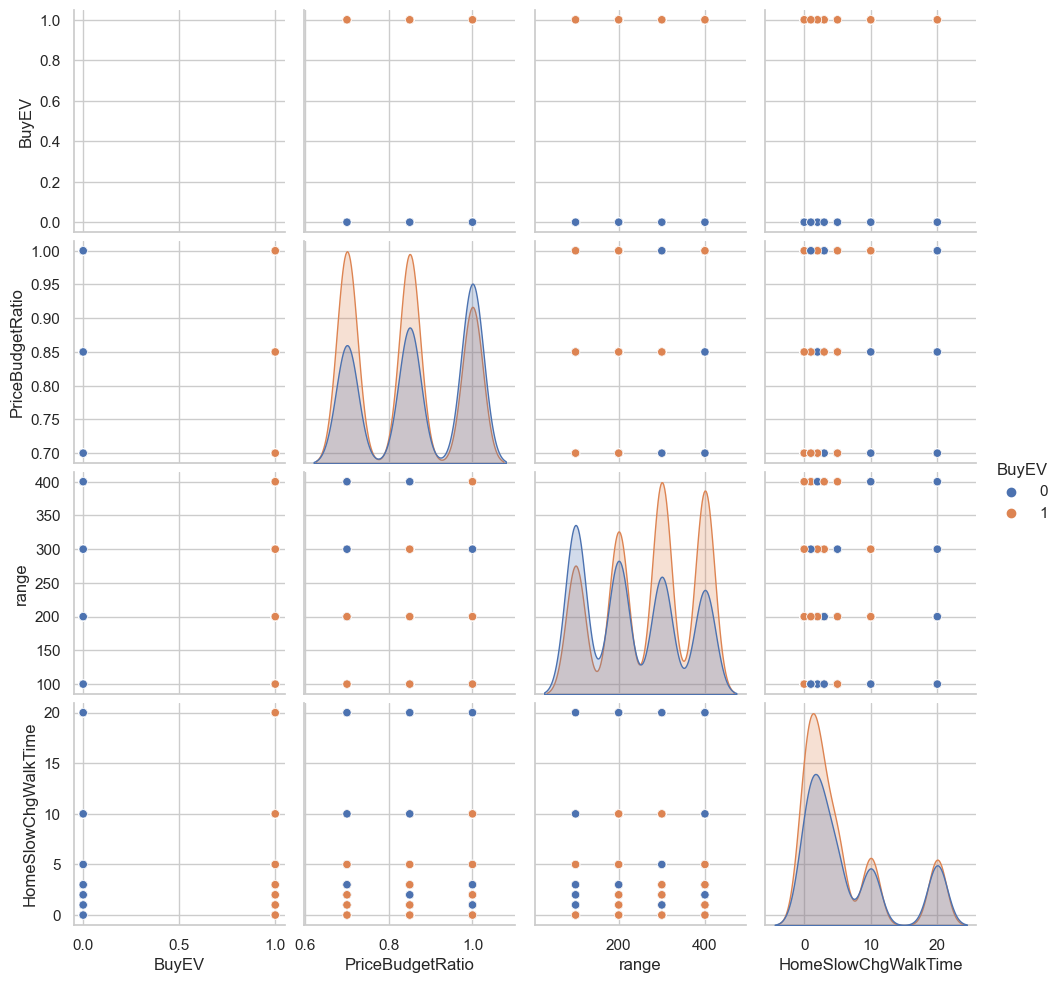

In [22]:
# Selecting a subset of numerical features for pairwise plots
selected_features = num_cols[:4]  # Adjust based on your interest
sns.pairplot(df_train, vars=selected_features, hue='BuyEV')
plt.show()

/var/folders/jk/swgq_ccj4wd23c8n457db82h0000gn/T/ipykernel_1004/2831935789.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_train, x=col, hue="BuyEV", fill=True, common_norm=False, alpha=0.5)


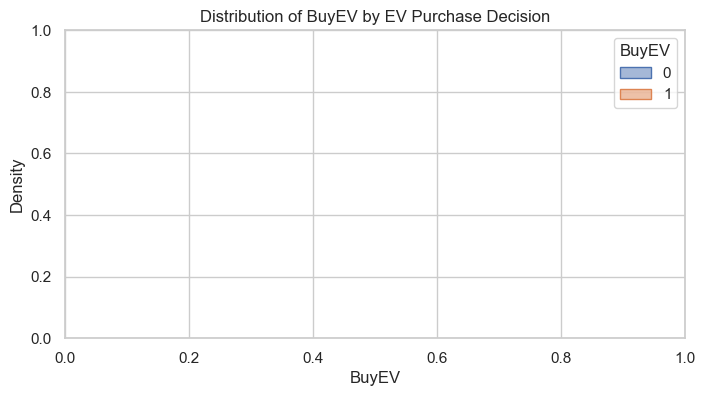

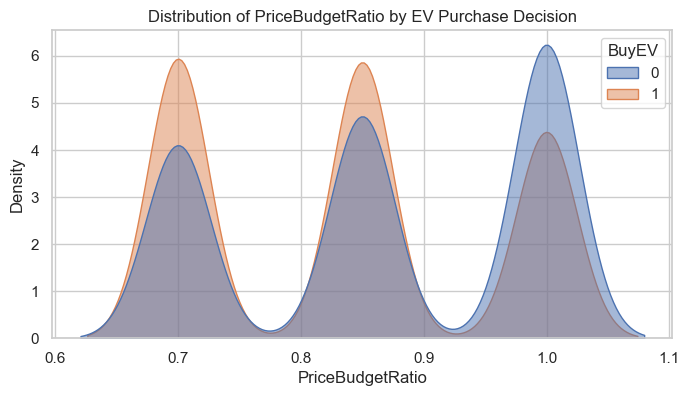

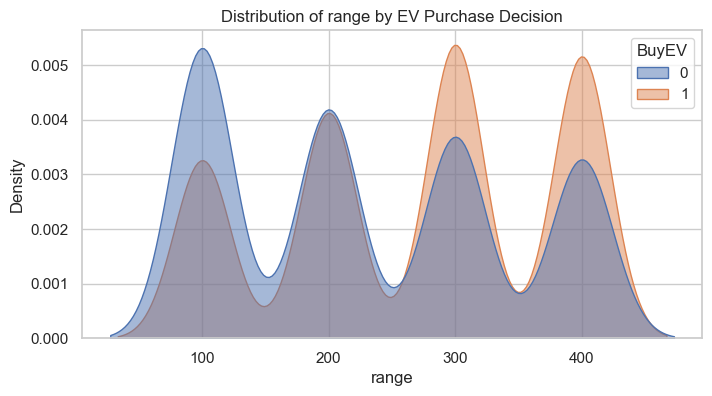

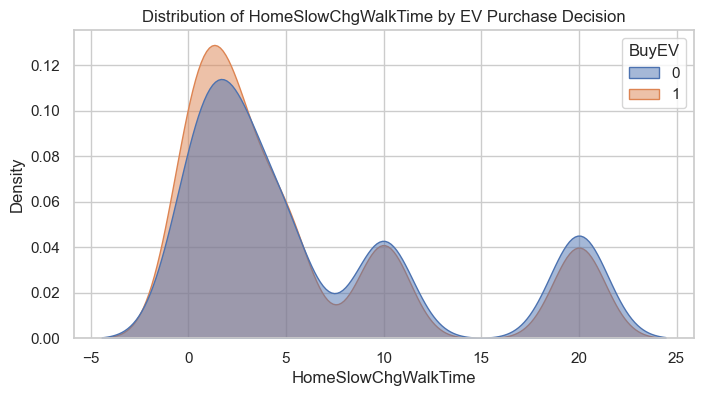

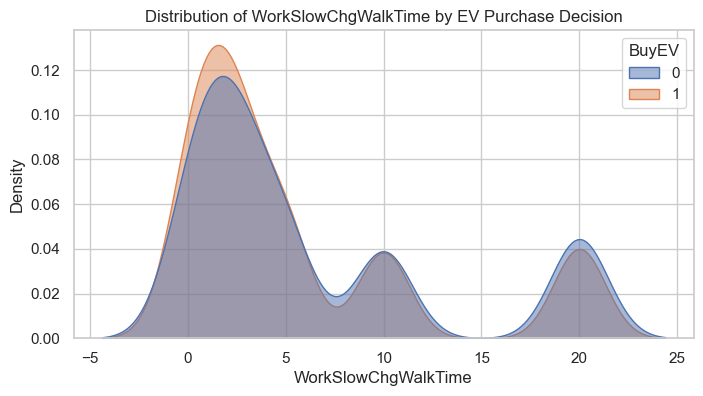

In [26]:
# Overlaying KDE plots for a numerical feature by EV purchase decision
for col in num_cols[:5]:  # Select a few key numerical features
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df_train, x=col, hue="BuyEV", fill=True, common_norm=False, alpha=0.5)
    plt.title(f'Distribution of {col} by EV Purchase Decision')
    plt.show()


# Parallel Coordinates Plot for Multivariate Analysis

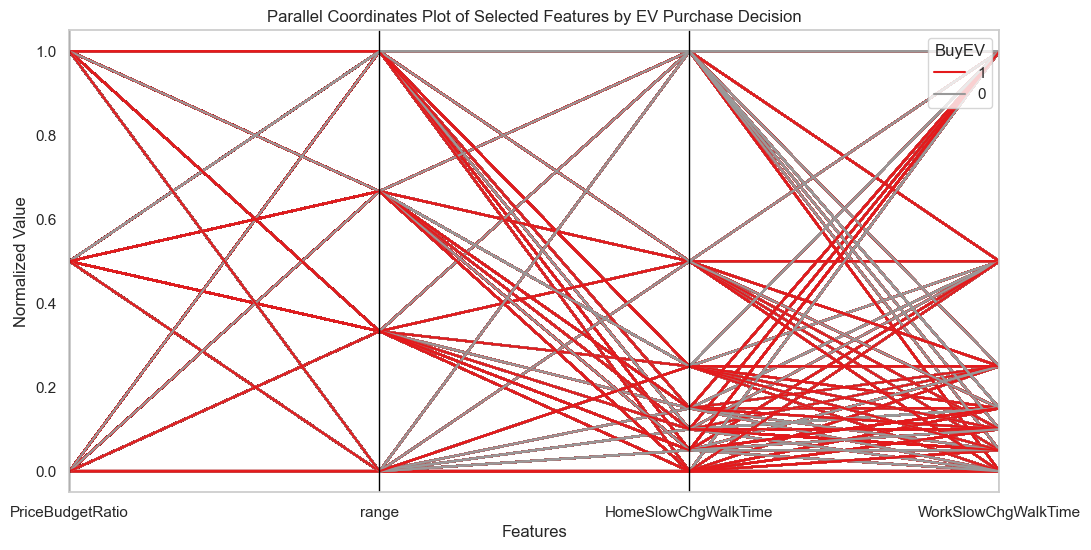

In [32]:
from pandas.plotting import parallel_coordinates

# Select a subset of numerical features for parallel coordinates plot
selected_features = num_cols[:5]  # Adjust based on your interest and preprocessing
df_subset = df_train[selected_features].copy()
df_subset['BuyEV'] = df_train['BuyEV']

# Normalize the features to improve readability
df_normalized = (df_subset[selected_features] - df_subset[selected_features].min()) / (df_subset[selected_features].max() - df_subset[selected_features].min())
df_normalized['BuyEV'] = df_subset['BuyEV']

# Parallel coordinates plot
plt.figure(figsize=(12, 6))
parallel_coordinates(df_normalized, 'BuyEV', colormap=plt.get_cmap("Set1"))
plt.title('Parallel Coordinates Plot of Selected Features by EV Purchase Decision')
plt.xlabel('Features')
plt.ylabel('Normalized Value')
plt.legend(title='BuyEV', loc='upper right')
plt.show()

# Conclusion and Recommendations:The RandomForestClassifier, with its optimized hyperparameters, emerged as the superior model for predicting potential EV buyers(79.66%)

Conclusion:
The RandomForestClassifier, with its optimized hyperparameters, emerged as the superior model for predicting potential EV buyers(79.66%). This model combines high accuracy with the ability to generalize well to new data, making it an invaluable tool for targeted marketing strategies aimed at promoting EV adoption. The comprehensive evaluation, including accuracy, precision, recall, and ROC AUC score, confirms the model's robustness and reliability in identifying likely EV purchasers.

Our analysis and modeling efforts have led to the development of robust predictive models with high accuracy and interpretability. The Random Forest and XGBoost models, in particular, showed promising results in predicting EV purchase likelihood.

Recommendations for Stakeholders:

Targeted Marketing: Utilize model insights to tailor marketing strategies towards individuals more likely to purchase EVs, potentially increasing conversion rates.
Policy Making: Inform policymakers about factors influencing EV adoption, supporting the development of targeted incentives or infrastructure improvements.
Further Research: Explore additional features that may influence EV purchase decisions, such as environmental awareness levels, to enhance model accuracy further.
Future Directions:

Model Interpretability: Implement techniques like SHAP (SHapley Additive exPlanations) to understand the impact of each feature on the prediction outcome.
Deployment: Develop a web application to allow stakeholders to input individual features and receive predictions in real-time, facilitating immediate decision-making.
Data Collection: Continuously update the dataset with new information to reflect changing market dynamics and consumer preferences, ensuring the model remains relevant and accurate over time.


